<a href="https://colab.research.google.com/github/rubithaganesh9-lgtm/rubithaganesh9-lgtm/blob/main/Rubitha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)

In [ ]:
df = pd.read_csv("/content/Phishing_Legitimate_full.csv")

print("✔ Dataset Loaded Successfully!\n")
print(df.head())


✔ Dataset Loaded Successfully!

   id  NumDots  SubdomainLevel  PathLevel  UrlLength  NumDash  \
0   1        3               1          5         72        0   
1   2        3               1          3        144        0   
2   3        3               1          2         58        0   
3   4        3               1          6         79        1   
4   5        3               0          4         46        0   

   NumDashInHostname  AtSymbol  TildeSymbol  NumUnderscore  ...  \
0                  0         0            0              0  ...   
1                  0         0            0              2  ...   
2                  0         0            0              0  ...   
3                  0         0            0              0  ...   
4                  0         0            0              0  ...   

   IframeOrFrame  MissingTitle  ImagesOnlyInForm  SubdomainLevelRT  \
0              0             0                 1                 1   
1              0             0    

In [ ]:
X = df.drop(["CLASS_LABEL", "id"], axis=1)      # <-- CLASS_LABEL column is the actual label; removing 'id' to prevent data leakage
y = df["CLASS_LABEL"]
numeric_cols = X.select_dtypes(include=['int64','float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
model.fit(X_train, y_train)
print("\n✔ Model Training Completed!")


✔ Model Training Completed!


In [ ]:
y_pred = model.predict(X_test)
# For multi-class classification, `predict_proba` returns probabilities for each class.
# For multi-class ROC AUC, we need probabilities for all classes.
y_prob_all_classes = model.predict_proba(X_test)

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
# For multi-class targets, specify an 'average' parameter for precision and recall.
# 'weighted' accounts for class imbalance.
print("Precision :", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall    :", recall_score(y_test, y_pred, average='weighted', zero_division=0))
# For binary classification, pass only the probabilities of the positive class (class 1).
# Remove multi_class and labels parameters for binary ROC AUC to avoid conflicts.
print("ROC-AUC   :", roc_auc_score(y_test, y_prob_all_classes[:, 1]))
print("==============================================\n")


============= MODEL PERFORMANCE ============
Accuracy  : 0.985
Precision : 0.985
Recall    : 0.985
ROC-AUC   : 0.9985722944103951



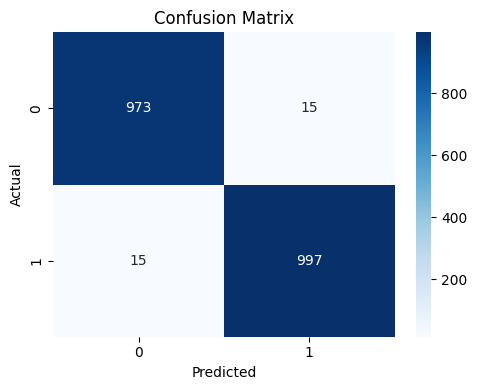

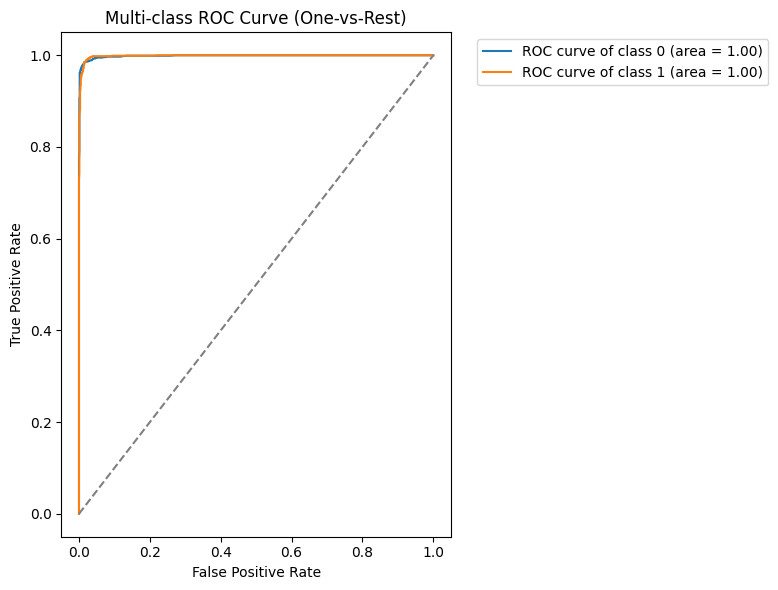

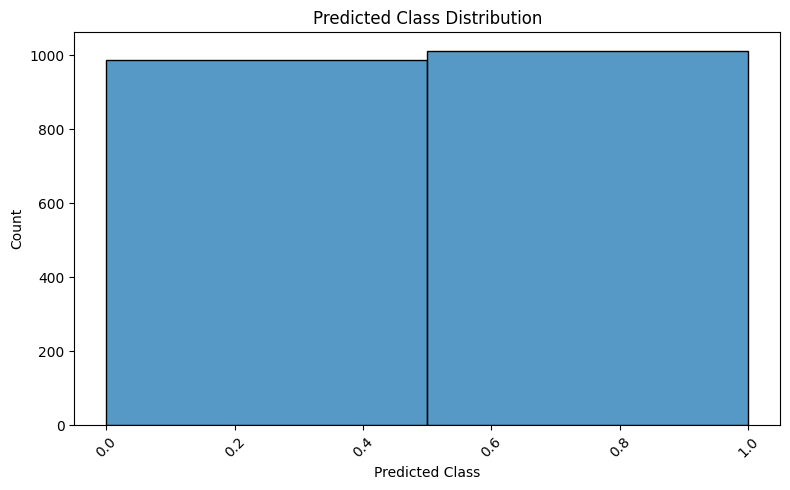

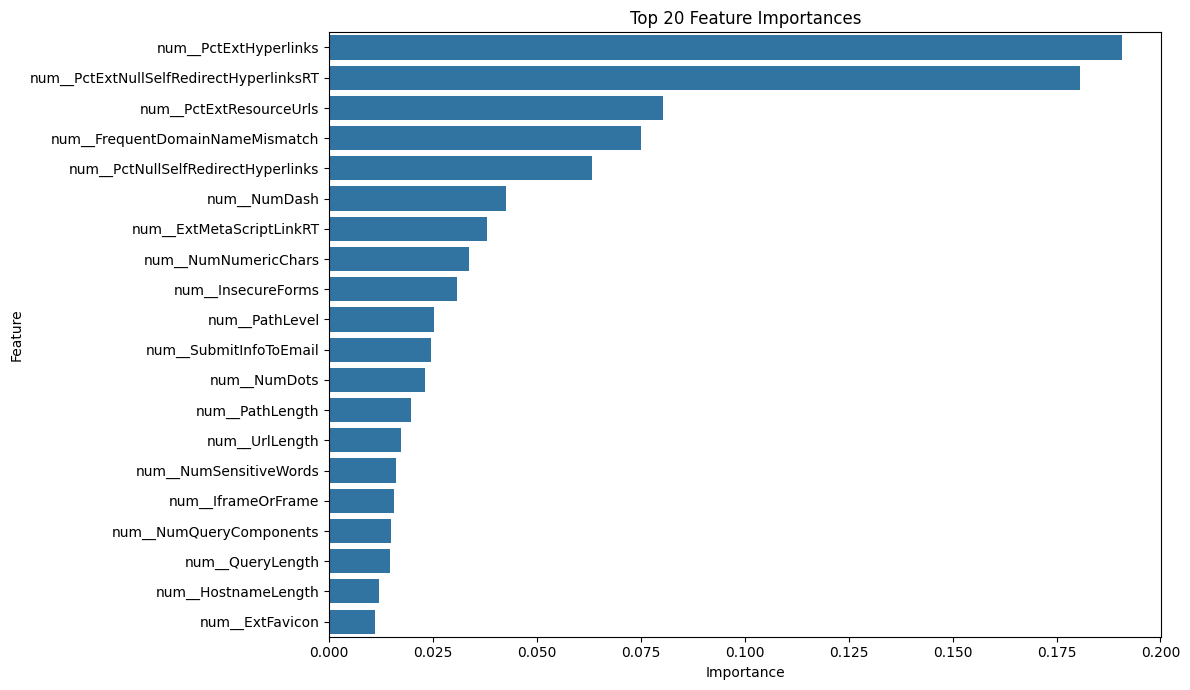

In [ ]:

# ---------- CONFUSION MATRIX ----------
cm = confusion_matrix(y_test, y_pred);

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(cls) for cls in model.classes_],
            yticklabels=[str(cls) for cls in model.classes_])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ---------- ROC CURVE ----------
# For multi-class ROC, calculate for each class using one-vs-rest strategy
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(model.classes_)

for i in range(n_classes):
    y_true_binary = (y_test == model.classes_[i]).astype(int)
    # Ensure y_prob_all_classes has columns for all classes present in y_test
    # and match the order if necessary. This check should prevent issues
    # if some classes are missing from predict_proba output.
    if i < y_prob_all_classes.shape[1]:
        fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_prob_all_classes[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        # Handle cases where a class might not have been predicted (e.g., due to sparse data)
        fpr[i], tpr[i], roc_auc[i] = None, None, None # Or some other placeholder

plt.figure(figsize=(8,6))
for i in range(n_classes):
    if roc_auc[i] is not None:
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {model.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---------- PROBABILITY HISTOGRAM ----------
# This histogram might not be as meaningful for multi-class prediction probabilities
# as it is for binary. Instead, let's visualize the distribution of predicted classes.
plt.figure(figsize=(8,5))
sns.histplot(y_pred, bins=len(model.classes_), kde=False)
plt.title("Predicted Class Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------- FEATURE IMPORTANCE ----------
# Check if the classifier has feature_importances_
if hasattr(model.named_steps['classifier'], 'feature_importances_'):
    importances = model.named_steps['classifier'].feature_importances_
    # Get all feature names after preprocessing from the fitted ColumnTransformer
    preprocessor = model.named_steps['preprocess']
    feature_names = preprocessor.get_feature_names_out() # Corrected line

    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Classifier does not have 'feature_importances_' attribute.")